### 中心节点操作流程
- 轨迹生成
- 聚类操作（kmedoids），但此时的聚类结果是无序的
- 原始数据网格化
- 聚类得到簇心结果，然后将所有网格化数据对这些簇心进行比较，从而得到有序的聚类结果

In [33]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics.cluster import adjusted_rand_score

from hausdorff import hausdorff_distance

from Bio.Cluster import kmedoids
import pickle
from itertools import combinations
import time

In [2]:
NODE_NUM = 3

In [3]:
def loadPara(k):
    allPara = []
    with open('para/node1paraK'+str(k)+'.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    with open('para/node2paraK'+str(k)+'.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    with open('para/node3paraK'+str(k)+'.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    return allPara

In [4]:
def dist(a,b):
    
    return hausdorff_distance(a,b)

In [5]:
def distMatrix(data):
    length = len(data)
    mat = [[]]
    for i in range(1,length):
        tmp = []
        for j in range(i):
            tmp.append(dist(np.array(data[i]),np.array(data[j])))
        mat.append(tmp) 
    return mat

In [6]:
#  clusterid 中的类号是指的是代表聚类中心的元素号。
def cluster(K,mat):
    clusterid, error, nfound = kmedoids(mat,K,npass = 100)
    return clusterid

In [7]:
def cost(data,labels):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(np.array(data[i]),np.array(data[labels[i]]))
    loss = loss / len(data)
    return loss

In [8]:
def chooseK(data,K,mat):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels = cluster(data,k,mat)
        y[k-3] = cost(data, labels)
    plt.xlabel('K')
    plt.ylabel('cost')
    plt.grid(True)
    plt.plot(x,y)
    plt.show()

In [9]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arr_x = np.array(df['x'][i:i+POINTS_NUM_PER_TR])
        arr_y = np.array(df['y'][i:i+POINTS_NUM_PER_TR])
        arr = np.append(arr_x,arr_y)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=POINTS_NUM_PER_TR
    return data

In [10]:
def discretization(data):
    
    # 网格坐标化
    data = np.round(data)
    tr_point = [    [  (data[j][i],data[j][i+POINTS_NUM_PER_TR])    for i in range(POINTS_NUM_PER_TR)]     
                           for j in range(len(data))]
    
    
    # 去掉连续落在同一区间上的点
    for i in range(len(tr_point)):
        tmp = []
        l = tr_point[i].copy()
        for j in range(POINTS_NUM_PER_TR-1):
            if l[j] == l[j+1]:
                tmp.append(j)
        tr_point[i] = [l[i] for i in range(POINTS_NUM_PER_TR) if i not in tmp]
        
    # 防止出现跨越的点
    for i in range(len(tr_point)):
        tmp = tr_point[i].copy()  # [(),(),...,()]
        count = 0 # 添加的点造成的偏移
        for j in range(len(tmp) - 1):
            now_p = tmp[j]
            next_p = tmp[j + 1]
            if not(tr_point[i][j + count] == now_p and tr_point[i][j + count + 1] == next_p):
                print('WRONGGGGG: ',now_p,next_p,tr_point[i][j + count],tr_point[i][j + count],)
                break
            if now_p[0] == next_p[0] and abs(now_p[1] - next_p[1]) == 1:
                continue
            elif abs(now_p[0] - next_p[0]) == 1 and now_p[1] == next_p[1]:
                continue   
            else:
                # print(now_p,next_p)
                delta_x = int(abs(now_p[0] - next_p[0]))
                delta_y = int(abs(now_p[1] - next_p[1]))
                if delta_x == 0:
                    step = (next_p[1] - now_p[1]) / delta_y
                    for k in range(1,delta_y,1):
                        tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                    count = count + delta_y - 1
                    continue
                elif delta_y == 0:
                    step = (next_p[0] - now_p[0])/delta_x
                    for k in range(1,delta_x,1):
                        tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                    count = count + delta_x - 1
                    continue
                else:
                    step_x = (next_p[0] - now_p[0])/delta_x
                    step_y = (next_p[1] - now_p[1]) / delta_y
                    k = 1
                    while delta_x != 0 and delta_y != 0:
                        tr_point[i].insert(j + count + 1,(now_p[0] + k * step_x,now_p[1]))
                        tr_point[i].insert(j + count + 2,(now_p[0] + k * step_x,now_p[1] + k * step_y))
                        count = count + 2
                        k = k + 1
                        delta_x = delta_x - 1
                        delta_y = delta_y - 1
                    if delta_x == 0 and delta_y == 0:
                        tr_point[i].pop(j + count)
                        count = count - 1
                    elif delta_x == 0:
                        step = (next_p[1] - now_p[1]) / delta_y
                        for k in range(1,delta_y,1):
                            tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                        count = count + delta_y - 1
                        continue
                    elif delta_y == 0:
                        step = (next_p[0] - now_p[0])/delta_x
                        for k in range(1,delta_x,1):
                            tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                        count = count + delta_x - 1
                        continue
                        
    return tr_point

In [11]:
def checkDiscTr(data):
    for index in range(len(data)):
        tr = data[index]
        for i in range(len(tr)-1):
            nowP = tr[i]
            nextP = tr[i+1]
            if np.abs(nextP[0]-nowP[0])+np.abs(nextP[1]-nowP[1]) > 1:
                print('wroooooooooooooong!!!')
                print(nowP,nextP,index)
            if np.abs(nextP[0]-nowP[0])+np.abs(nextP[1]-nowP[1]) == 0:
                print('wroooooooooooooong!!!')
                print(nowP,nextP,index)

In [61]:
def RI(a,b):
    ss = 0
    dd = 0
    suma = 0
    for com in combinations(range(len(a)),2):
        suma = suma + 1
        if (a[com[0]] == a[com[1]]) and (b[com[0]] == b[com[1]]):
            ss = ss + 1
        if (a[com[0]] != a[com[1]]) and (b[com[0]] != b[com[1]]):
            dd = dd + 1
    return (ss + dd) / suma

In [13]:
def stableClustering(data,k,mat):
    labels = cluster(k,mat)  # [121,111,123,123,121,111,...]
    min_cost = cost(data,labels)
    for i in range(50): # 取50次聚类中损失函数最小的
        labels_ = cluster(k,mat)
        cost_ = cost(data,labels_)
        if cost_ < min_cost:
            labels = labels_
            min_cost = cost_
    print('min_cost:'+str(min_cost))
    return labels

In [14]:
def getLabelResult(originalData,data,centers):
    result = []
    for i in originalData:
        distArr = []
        for j in range(len(centers)):
            distArr.append(hausdorff_distance(np.array(i),np.array(data[centers[j]])))
        minDist = np.min(distArr)
        result.append(distArr.index(minDist))
    return result

In [31]:
def trGendrator(allPara):
    returnTr = []
    for node in range(NODE_NUM):
        # 每个节点
        nodePara = allPara[node]
        for j in range(len(nodePara)):
            
           
            # 每个子簇
            cPara = nodePara[j]
            
            firstPoints = cPara['firstP']
            lastPoints = cPara['lastP']
            allState = cPara['allS']
            transMatrix = pd.DataFrame(cPara['transM'].A,columns = pd.MultiIndex.from_tuples(allState),  index = pd.MultiIndex.from_tuples(allState))
            minmaxLength = cPara['minmaxL']
            
            minLength = minmaxLength[0]
            maxLength = minmaxLength[1]
            
            for i in range(len(firstPoints)):
                print('第'+str(node+1)+'个节点，第'+str(j+1)+'个子簇，'+'第'+str(i+1)+'条轨迹......')
                # 每条轨迹
                genTr = []
                nowP = firstPoints[i]
                genTr.append(nowP)
                start = time.time()
                while(True):
                    
                    end = time.time()
                    if(end - start > 120): # 如果总是迭代不出来，补救措施
                        print('补救一下')
                        df = pd.read_csv('./data/node'+str(node+1)+'.csv')
                        data = df2array(df)
                        disc_data = discretization(data)
                        for trrr in disc_data:
                            if nowP == trrr[0] and len(trrr) > minLength and len(trrr) < maxLength:
                                genTr = trrr
                                break
                        break
                        
                    pro = list(transMatrix.loc[nowP])
                    
                    if np.isnan(pro[0]):
                        if len(genTr) < minLength or len(genTr) > maxLength:
                            #print('1.长度为'+str(len(genTr))+'长度不合适')
                            genTr = []                           
                            nowP = firstPoints[i]
                            genTr.append(nowP)
                            continue
                        else:
                            break
                            
                    n = np.random.choice(len(allState),1,p = pro)
                    nextP = allState[n[0]]
                    
                    # 检查是否生成了不合规的网格点
                    if np.abs(nextP[0]-nowP[0]) + np.abs(nextP[1]-nowP[1]) > 1:
                        print('wroooooooooooooong!!!')
                        print(nowP,nextP,index)
                    if np.abs(nextP[0]-nowP[0]) + np.abs(nextP[1]-nowP[1]) == 0:
                        print('wroooooooooooooong!!!')
                        print(nowP,nextP,index)  
                        print(pro)
                        
                    if nextP in lastPoints:  # 因为有可能是last point，但是概率分布不是nan
                        genTr.append(nextP)
                        if len(genTr) < minLength:
                            nowP = nextP
                            continue
                        elif len(genTr) > maxLength:
                            #print('2.长度为'+str(len(genTr))+'长度不合适')
                            genTr = []
                            nowP = firstPoints[i]
                            genTr.append(nowP)
                            continue
                        else:
                            break
                            
                    genTr.append(nextP)
                    if len(genTr) > maxLength:
                        #print('3.长度为'+str(len(genTr))+'长度不合适')
                        genTr = []                       
                        nowP = firstPoints[i]
                        genTr.append(nowP)
                        continue
                        
                    nowP = nextP
                
                returnTr.append(genTr)
    return returnTr

#### ================加载参数，生成轨迹================

In [16]:
def init():
    df = pd.read_csv('data/all.csv')

    num_tr = int(len(df)/POINTS_NUM_PER_TR)
    print('num_tr:'+str(num_tr))

    disc_data = discretization(df2array(df))
    return disc_data

In [17]:
POINTS_NUM_PER_TR = 500

In [18]:
DISC_DATA = init()

num_tr:532


In [50]:
with open('baseline3.pickle','rb') as f:
    baseline3 = pickle.load(f)
with open('baseline4.pickle','rb') as f:
    baseline4 = pickle.load(f)
with open('baseline5.pickle','rb') as f:
    baseline5 = pickle.load(f)

In [34]:
GEN_TR3 = trGendrator(loadPara(3))
MAT3 = distMatrix(GEN_TR3)

第1个节点，第1个子簇，第1条轨迹......
第1个节点，第1个子簇，第2条轨迹......
第1个节点，第1个子簇，第3条轨迹......
第1个节点，第1个子簇，第4条轨迹......
第1个节点，第1个子簇，第5条轨迹......
第1个节点，第1个子簇，第6条轨迹......
第1个节点，第1个子簇，第7条轨迹......
第1个节点，第1个子簇，第8条轨迹......
第1个节点，第1个子簇，第9条轨迹......
第1个节点，第1个子簇，第10条轨迹......
第1个节点，第1个子簇，第11条轨迹......
第1个节点，第1个子簇，第12条轨迹......
第1个节点，第1个子簇，第13条轨迹......
第1个节点，第1个子簇，第14条轨迹......
第1个节点，第1个子簇，第15条轨迹......
第1个节点，第1个子簇，第16条轨迹......
第1个节点，第1个子簇，第17条轨迹......
第1个节点，第1个子簇，第18条轨迹......
第1个节点，第1个子簇，第19条轨迹......
第1个节点，第1个子簇，第20条轨迹......
第1个节点，第1个子簇，第21条轨迹......
第1个节点，第1个子簇，第22条轨迹......
第1个节点，第1个子簇，第23条轨迹......
第1个节点，第1个子簇，第24条轨迹......
第1个节点，第1个子簇，第25条轨迹......
第1个节点，第1个子簇，第26条轨迹......
第1个节点，第1个子簇，第27条轨迹......
第1个节点，第1个子簇，第28条轨迹......
第1个节点，第1个子簇，第29条轨迹......
第1个节点，第1个子簇，第30条轨迹......
第1个节点，第1个子簇，第31条轨迹......
第1个节点，第1个子簇，第32条轨迹......
第1个节点，第1个子簇，第33条轨迹......
第1个节点，第1个子簇，第34条轨迹......
第1个节点，第1个子簇，第35条轨迹......
第1个节点，第1个子簇，第36条轨迹......
第1个节点，第1个子簇，第37条轨迹......
第1个节点，第1个子簇，第38条轨迹......
第1个节点，第1个子簇，第39条轨迹......
第1个节点，第1个子簇，第40条轨迹......
第1个节点，第1个

第2个节点，第3个子簇，第21条轨迹......
第2个节点，第3个子簇，第22条轨迹......
第2个节点，第3个子簇，第23条轨迹......
第2个节点，第3个子簇，第24条轨迹......
第2个节点，第3个子簇，第25条轨迹......
第2个节点，第3个子簇，第26条轨迹......
第2个节点，第3个子簇，第27条轨迹......
第2个节点，第3个子簇，第28条轨迹......
第2个节点，第3个子簇，第29条轨迹......
第2个节点，第3个子簇，第30条轨迹......
第2个节点，第3个子簇，第31条轨迹......
第2个节点，第3个子簇，第32条轨迹......
第2个节点，第3个子簇，第33条轨迹......
第2个节点，第3个子簇，第34条轨迹......
第2个节点，第3个子簇，第35条轨迹......
第2个节点，第3个子簇，第36条轨迹......
第2个节点，第3个子簇，第37条轨迹......
第2个节点，第3个子簇，第38条轨迹......
第2个节点，第3个子簇，第39条轨迹......
第2个节点，第3个子簇，第40条轨迹......
第2个节点，第3个子簇，第41条轨迹......
第2个节点，第3个子簇，第42条轨迹......
第3个节点，第1个子簇，第1条轨迹......
第3个节点，第1个子簇，第2条轨迹......
第3个节点，第1个子簇，第3条轨迹......
第3个节点，第1个子簇，第4条轨迹......
第3个节点，第1个子簇，第5条轨迹......
补救一下
第3个节点，第1个子簇，第6条轨迹......
第3个节点，第1个子簇，第7条轨迹......
第3个节点，第1个子簇，第8条轨迹......
第3个节点，第1个子簇，第9条轨迹......
第3个节点，第1个子簇，第10条轨迹......
第3个节点，第1个子簇，第11条轨迹......
第3个节点，第1个子簇，第12条轨迹......
第3个节点，第1个子簇，第13条轨迹......
第3个节点，第1个子簇，第14条轨迹......
第3个节点，第1个子簇，第15条轨迹......
第3个节点，第1个子簇，第16条轨迹......
第3个节点，第1个子簇，第17条轨迹......
第3个节点，第1个子簇，第18条轨迹......
第3个节

In [35]:
len(GEN_TR3)

532

In [36]:
checkDiscTr(GEN_TR3)

In [41]:
GEN_TR10 = trGendrator(loadPara(10))
MAT10 = distMatrix(GEN_TR10)

第1个节点，第1个子簇，第1条轨迹......
第1个节点，第1个子簇，第2条轨迹......
第1个节点，第1个子簇，第3条轨迹......
第1个节点，第1个子簇，第4条轨迹......
第1个节点，第2个子簇，第1条轨迹......
第1个节点，第2个子簇，第2条轨迹......
第1个节点，第2个子簇，第3条轨迹......
第1个节点，第2个子簇，第4条轨迹......
第1个节点，第2个子簇，第5条轨迹......
第1个节点，第2个子簇，第6条轨迹......
第1个节点，第2个子簇，第7条轨迹......
第1个节点，第2个子簇，第8条轨迹......
第1个节点，第2个子簇，第9条轨迹......
第1个节点，第2个子簇，第10条轨迹......
第1个节点，第2个子簇，第11条轨迹......
第1个节点，第2个子簇，第12条轨迹......
第1个节点，第2个子簇，第13条轨迹......
第1个节点，第2个子簇，第14条轨迹......
第1个节点，第2个子簇，第15条轨迹......
第1个节点，第2个子簇，第16条轨迹......
第1个节点，第3个子簇，第1条轨迹......
第1个节点，第3个子簇，第2条轨迹......
第1个节点，第3个子簇，第3条轨迹......
第1个节点，第3个子簇，第4条轨迹......
第1个节点，第3个子簇，第5条轨迹......
第1个节点，第3个子簇，第6条轨迹......
第1个节点，第3个子簇，第7条轨迹......
第1个节点，第3个子簇，第8条轨迹......
第1个节点，第3个子簇，第9条轨迹......
第1个节点，第3个子簇，第10条轨迹......
第1个节点，第3个子簇，第11条轨迹......
第1个节点，第3个子簇，第12条轨迹......
第1个节点，第3个子簇，第13条轨迹......
第1个节点，第3个子簇，第14条轨迹......
第1个节点，第3个子簇，第15条轨迹......
第1个节点，第4个子簇，第1条轨迹......
第1个节点，第4个子簇，第2条轨迹......
第1个节点，第4个子簇，第3条轨迹......
第1个节点，第4个子簇，第4条轨迹......
第1个节点，第4个子簇，第5条轨迹......
第1个节点，第4个子簇，第6条轨迹......
第1个

第2个节点，第10个子簇，第2条轨迹......
第2个节点，第10个子簇，第3条轨迹......
第2个节点，第10个子簇，第4条轨迹......
第2个节点，第10个子簇，第5条轨迹......
第2个节点，第10个子簇，第6条轨迹......
第2个节点，第10个子簇，第7条轨迹......
第2个节点，第10个子簇，第8条轨迹......
第2个节点，第10个子簇，第9条轨迹......
第2个节点，第10个子簇，第10条轨迹......
第2个节点，第10个子簇，第11条轨迹......
第2个节点，第10个子簇，第12条轨迹......
第2个节点，第10个子簇，第13条轨迹......
第2个节点，第10个子簇，第14条轨迹......
第2个节点，第10个子簇，第15条轨迹......
第2个节点，第10个子簇，第16条轨迹......
第2个节点，第10个子簇，第17条轨迹......
第2个节点，第10个子簇，第18条轨迹......
第2个节点，第10个子簇，第19条轨迹......
第2个节点，第10个子簇，第20条轨迹......
第2个节点，第10个子簇，第21条轨迹......
第2个节点，第10个子簇，第22条轨迹......
第3个节点，第1个子簇，第1条轨迹......
第3个节点，第1个子簇，第2条轨迹......
第3个节点，第1个子簇，第3条轨迹......
第3个节点，第1个子簇，第4条轨迹......
第3个节点，第1个子簇，第5条轨迹......
第3个节点，第1个子簇，第6条轨迹......
第3个节点，第1个子簇，第7条轨迹......
第3个节点，第1个子簇，第8条轨迹......
第3个节点，第1个子簇，第9条轨迹......
第3个节点，第1个子簇，第10条轨迹......
第3个节点，第1个子簇，第11条轨迹......
第3个节点，第1个子簇，第12条轨迹......
第3个节点，第1个子簇，第13条轨迹......
第3个节点，第1个子簇，第14条轨迹......
第3个节点，第1个子簇，第15条轨迹......
第3个节点，第1个子簇，第16条轨迹......
第3个节点，第2个子簇，第1条轨迹......
第3个节点，第2个子簇，第2条轨迹......
第3个节点，第2个子簇，第3条轨迹......

In [42]:
len(GEN_TR10)

532

In [43]:
checkDiscTr(GEN_TR10)

In [46]:
GEN_TR20 = trGendrator(loadPara(20))
MAT20 = distMatrix(GEN_TR20)
print(len(GEN_TR20))
checkDiscTr(GEN_TR20)

第1个节点，第1个子簇，第1条轨迹......
第1个节点，第1个子簇，第2条轨迹......
第1个节点，第1个子簇，第3条轨迹......
第1个节点，第1个子簇，第4条轨迹......
第1个节点，第1个子簇，第5条轨迹......
第1个节点，第1个子簇，第6条轨迹......
第1个节点，第1个子簇，第7条轨迹......
第1个节点，第1个子簇，第8条轨迹......
第1个节点，第1个子簇，第9条轨迹......
第1个节点，第1个子簇，第10条轨迹......
第1个节点，第1个子簇，第11条轨迹......
第1个节点，第1个子簇，第12条轨迹......
第1个节点，第1个子簇，第13条轨迹......
第1个节点，第1个子簇，第14条轨迹......
第1个节点，第1个子簇，第15条轨迹......
第1个节点，第1个子簇，第16条轨迹......
第1个节点，第1个子簇，第17条轨迹......
第1个节点，第1个子簇，第18条轨迹......
第1个节点，第1个子簇，第19条轨迹......
第1个节点，第1个子簇，第20条轨迹......
第1个节点，第1个子簇，第21条轨迹......
第1个节点，第1个子簇，第22条轨迹......
第1个节点，第1个子簇，第23条轨迹......
第1个节点，第1个子簇，第24条轨迹......
第1个节点，第1个子簇，第25条轨迹......
第1个节点，第1个子簇，第26条轨迹......
第1个节点，第1个子簇，第27条轨迹......
第1个节点，第1个子簇，第28条轨迹......
第1个节点，第1个子簇，第29条轨迹......
第1个节点，第1个子簇，第30条轨迹......
第1个节点，第2个子簇，第1条轨迹......
第1个节点，第2个子簇，第2条轨迹......
第1个节点，第2个子簇，第3条轨迹......
第1个节点，第2个子簇，第4条轨迹......
第1个节点，第2个子簇，第5条轨迹......
第1个节点，第2个子簇，第6条轨迹......
第1个节点，第2个子簇，第7条轨迹......
第1个节点，第2个子簇，第8条轨迹......
第1个节点，第2个子簇，第9条轨迹......
第1个节点，第2个子簇，第10条轨迹......
第1个节点，第2个子簇，第11条轨迹

第2个节点，第17个子簇，第18条轨迹......
第2个节点，第18个子簇，第1条轨迹......
第2个节点，第18个子簇，第2条轨迹......
第2个节点，第18个子簇，第3条轨迹......
第2个节点，第18个子簇，第4条轨迹......
第2个节点，第18个子簇，第5条轨迹......
第2个节点，第18个子簇，第6条轨迹......
第2个节点，第18个子簇，第7条轨迹......
第2个节点，第19个子簇，第1条轨迹......
第2个节点，第19个子簇，第2条轨迹......
第2个节点，第19个子簇，第3条轨迹......
第2个节点，第19个子簇，第4条轨迹......
第2个节点，第19个子簇，第5条轨迹......
第2个节点，第19个子簇，第6条轨迹......
第2个节点，第19个子簇，第7条轨迹......
第2个节点，第19个子簇，第8条轨迹......
第2个节点，第19个子簇，第9条轨迹......
第2个节点，第19个子簇，第10条轨迹......
第2个节点，第19个子簇，第11条轨迹......
第2个节点，第19个子簇，第12条轨迹......
第2个节点，第19个子簇，第13条轨迹......
第2个节点，第20个子簇，第1条轨迹......
第3个节点，第1个子簇，第1条轨迹......
第3个节点，第1个子簇，第2条轨迹......
第3个节点，第1个子簇，第3条轨迹......
第3个节点，第1个子簇，第4条轨迹......
第3个节点，第1个子簇，第5条轨迹......
第3个节点，第1个子簇，第6条轨迹......
第3个节点，第1个子簇，第7条轨迹......
第3个节点，第1个子簇，第8条轨迹......
第3个节点，第1个子簇，第9条轨迹......
第3个节点，第1个子簇，第10条轨迹......
第3个节点，第2个子簇，第1条轨迹......
第3个节点，第2个子簇，第2条轨迹......
第3个节点，第2个子簇，第3条轨迹......
第3个节点，第2个子簇，第4条轨迹......
第3个节点，第2个子簇，第5条轨迹......
第3个节点，第2个子簇，第6条轨迹......
第3个节点，第2个子簇，第7条轨迹......
第3个节点，第2个子簇，第8条轨迹......
第3个节点，第2个子簇，

In [80]:
GEN_TR6 = trGendrator(loadPara(6))
MAT6 = distMatrix(GEN_TR6)
print(len(GEN_TR6))
checkDiscTr(GEN_TR6)

第1个节点，第1个子簇，第1条轨迹......
第1个节点，第1个子簇，第2条轨迹......
第1个节点，第1个子簇，第3条轨迹......
第1个节点，第1个子簇，第4条轨迹......
第1个节点，第1个子簇，第5条轨迹......
第1个节点，第1个子簇，第6条轨迹......
第1个节点，第1个子簇，第7条轨迹......
第1个节点，第1个子簇，第8条轨迹......
第1个节点，第1个子簇，第9条轨迹......
第1个节点，第1个子簇，第10条轨迹......
第1个节点，第1个子簇，第11条轨迹......
第1个节点，第1个子簇，第12条轨迹......
第1个节点，第1个子簇，第13条轨迹......
第1个节点，第1个子簇，第14条轨迹......
第1个节点，第1个子簇，第15条轨迹......
第1个节点，第1个子簇，第16条轨迹......
第1个节点，第1个子簇，第17条轨迹......
第1个节点，第1个子簇，第18条轨迹......
第1个节点，第1个子簇，第19条轨迹......
第1个节点，第1个子簇，第20条轨迹......
第1个节点，第1个子簇，第21条轨迹......
第1个节点，第1个子簇，第22条轨迹......
第1个节点，第1个子簇，第23条轨迹......
第1个节点，第1个子簇，第24条轨迹......
第1个节点，第1个子簇，第25条轨迹......
第1个节点，第1个子簇，第26条轨迹......
第1个节点，第1个子簇，第27条轨迹......
第1个节点，第1个子簇，第28条轨迹......
第1个节点，第1个子簇，第29条轨迹......
第1个节点，第1个子簇，第30条轨迹......
第1个节点，第1个子簇，第31条轨迹......
第1个节点，第1个子簇，第32条轨迹......
第1个节点，第1个子簇，第33条轨迹......
第1个节点，第1个子簇，第34条轨迹......
第1个节点，第1个子簇，第35条轨迹......
第1个节点，第1个子簇，第36条轨迹......
第1个节点，第1个子簇，第37条轨迹......
第1个节点，第1个子簇，第38条轨迹......
第1个节点，第1个子簇，第39条轨迹......
第1个节点，第1个子簇，第40条轨迹......
第1个节点，第1个

第2个节点，第6个子簇，第9条轨迹......
第2个节点，第6个子簇，第10条轨迹......
第2个节点，第6个子簇，第11条轨迹......
第2个节点，第6个子簇，第12条轨迹......
第2个节点，第6个子簇，第13条轨迹......
第2个节点，第6个子簇，第14条轨迹......
第2个节点，第6个子簇，第15条轨迹......
第2个节点，第6个子簇，第16条轨迹......
第2个节点，第6个子簇，第17条轨迹......
第2个节点，第6个子簇，第18条轨迹......
第2个节点，第6个子簇，第19条轨迹......
第2个节点，第6个子簇，第20条轨迹......
第2个节点，第6个子簇，第21条轨迹......
第2个节点，第6个子簇，第22条轨迹......
第2个节点，第6个子簇，第23条轨迹......
第2个节点，第6个子簇，第24条轨迹......
第2个节点，第6个子簇，第25条轨迹......
第2个节点，第6个子簇，第26条轨迹......
第2个节点，第6个子簇，第27条轨迹......
第2个节点，第6个子簇，第28条轨迹......
第2个节点，第6个子簇，第29条轨迹......
第2个节点，第6个子簇，第30条轨迹......
第3个节点，第1个子簇，第1条轨迹......
第3个节点，第1个子簇，第2条轨迹......
第3个节点，第1个子簇，第3条轨迹......
第3个节点，第1个子簇，第4条轨迹......
第3个节点，第1个子簇，第5条轨迹......
第3个节点，第1个子簇，第6条轨迹......
第3个节点，第1个子簇，第7条轨迹......
第3个节点，第1个子簇，第8条轨迹......
第3个节点，第1个子簇，第9条轨迹......
第3个节点，第1个子簇，第10条轨迹......
第3个节点，第1个子簇，第11条轨迹......
第3个节点，第1个子簇，第12条轨迹......
第3个节点，第1个子簇，第13条轨迹......
第3个节点，第1个子簇，第14条轨迹......
第3个节点，第1个子簇，第15条轨迹......
第3个节点，第1个子簇，第16条轨迹......
第3个节点，第1个子簇，第17条轨迹......
第3个节点，第1个子簇，第18条轨迹......
第3个节点，第1个子

In [82]:
GEN_TR8 = trGendrator(loadPara(8))
MAT8 = distMatrix(GEN_TR8)
print(len(GEN_TR8))
checkDiscTr(GEN_TR8)

第1个节点，第1个子簇，第1条轨迹......
第1个节点，第1个子簇，第2条轨迹......
第1个节点，第1个子簇，第3条轨迹......
第1个节点，第1个子簇，第4条轨迹......
第1个节点，第1个子簇，第5条轨迹......
第1个节点，第1个子簇，第6条轨迹......
第1个节点，第1个子簇，第7条轨迹......
第1个节点，第1个子簇，第8条轨迹......
第1个节点，第1个子簇，第9条轨迹......
第1个节点，第1个子簇，第10条轨迹......
第1个节点，第1个子簇，第11条轨迹......
第1个节点，第1个子簇，第12条轨迹......
第1个节点，第1个子簇，第13条轨迹......
第1个节点，第1个子簇，第14条轨迹......
第1个节点，第1个子簇，第15条轨迹......
第1个节点，第1个子簇，第16条轨迹......
第1个节点，第1个子簇，第17条轨迹......
第1个节点，第1个子簇，第18条轨迹......
第1个节点，第1个子簇，第19条轨迹......
第1个节点，第1个子簇，第20条轨迹......
第1个节点，第1个子簇，第21条轨迹......
第1个节点，第1个子簇，第22条轨迹......
第1个节点，第1个子簇，第23条轨迹......
第1个节点，第2个子簇，第1条轨迹......
第1个节点，第2个子簇，第2条轨迹......
第1个节点，第2个子簇，第3条轨迹......
第1个节点，第2个子簇，第4条轨迹......
第1个节点，第2个子簇，第5条轨迹......
第1个节点，第2个子簇，第6条轨迹......
第1个节点，第2个子簇，第7条轨迹......
第1个节点，第2个子簇，第8条轨迹......
第1个节点，第2个子簇，第9条轨迹......
第1个节点，第2个子簇，第10条轨迹......
第1个节点，第2个子簇，第11条轨迹......
第1个节点，第2个子簇，第12条轨迹......
第1个节点，第2个子簇，第13条轨迹......
第1个节点，第2个子簇，第14条轨迹......
第1个节点，第2个子簇，第15条轨迹......
第1个节点，第2个子簇，第16条轨迹......
第1个节点，第2个子簇，第17条轨迹......
第1个节点，第2个子簇，第18条轨迹

第2个节点，第8个子簇，第5条轨迹......
第2个节点，第8个子簇，第6条轨迹......
第2个节点，第8个子簇，第7条轨迹......
第2个节点，第8个子簇，第8条轨迹......
第2个节点，第8个子簇，第9条轨迹......
第2个节点，第8个子簇，第10条轨迹......
第2个节点，第8个子簇，第11条轨迹......
第2个节点，第8个子簇，第12条轨迹......
第2个节点，第8个子簇，第13条轨迹......
第2个节点，第8个子簇，第14条轨迹......
第2个节点，第8个子簇，第15条轨迹......
第2个节点，第8个子簇，第16条轨迹......
第2个节点，第8个子簇，第17条轨迹......
第2个节点，第8个子簇，第18条轨迹......
第2个节点，第8个子簇，第19条轨迹......
第2个节点，第8个子簇，第20条轨迹......
第2个节点，第8个子簇，第21条轨迹......
第2个节点，第8个子簇，第22条轨迹......
第3个节点，第1个子簇，第1条轨迹......
第3个节点，第1个子簇，第2条轨迹......
第3个节点，第1个子簇，第3条轨迹......
第3个节点，第1个子簇，第4条轨迹......
第3个节点，第1个子簇，第5条轨迹......
第3个节点，第1个子簇，第6条轨迹......
第3个节点，第1个子簇，第7条轨迹......
第3个节点，第1个子簇，第8条轨迹......
第3个节点，第1个子簇，第9条轨迹......
第3个节点，第1个子簇，第10条轨迹......
第3个节点，第1个子簇，第11条轨迹......
第3个节点，第1个子簇，第12条轨迹......
第3个节点，第1个子簇，第13条轨迹......
第3个节点，第1个子簇，第14条轨迹......
第3个节点，第1个子簇，第15条轨迹......
第3个节点，第1个子簇，第16条轨迹......
第3个节点，第1个子簇，第17条轨迹......
第3个节点，第1个子簇，第18条轨迹......
第3个节点，第2个子簇，第1条轨迹......
第3个节点，第2个子簇，第2条轨迹......
第3个节点，第2个子簇，第3条轨迹......
第3个节点，第2个子簇，第4条轨迹......
第3个节点，第2个子簇，第5条轨迹.

In [78]:
GEN_TR15 = trGendrator(loadPara(15))
MAT15 = distMatrix(GEN_TR15)
print(len(GEN_TR15))
checkDiscTr(GEN_TR15)

第1个节点，第1个子簇，第1条轨迹......
第1个节点，第1个子簇，第2条轨迹......
第1个节点，第1个子簇，第3条轨迹......
第1个节点，第1个子簇，第4条轨迹......
第1个节点，第1个子簇，第5条轨迹......
第1个节点，第1个子簇，第6条轨迹......
第1个节点，第1个子簇，第7条轨迹......
第1个节点，第1个子簇，第8条轨迹......
第1个节点，第1个子簇，第9条轨迹......
第1个节点，第1个子簇，第10条轨迹......
第1个节点，第1个子簇，第11条轨迹......
第1个节点，第1个子簇，第12条轨迹......
第1个节点，第1个子簇，第13条轨迹......
第1个节点，第1个子簇，第14条轨迹......
第1个节点，第1个子簇，第15条轨迹......
第1个节点，第1个子簇，第16条轨迹......
第1个节点，第1个子簇，第17条轨迹......
第1个节点，第1个子簇，第18条轨迹......
第1个节点，第1个子簇，第19条轨迹......
第1个节点，第1个子簇，第20条轨迹......
第1个节点，第1个子簇，第21条轨迹......
第1个节点，第1个子簇，第22条轨迹......
第1个节点，第1个子簇，第23条轨迹......
第1个节点，第1个子簇，第24条轨迹......
第1个节点，第1个子簇，第25条轨迹......
第1个节点，第1个子簇，第26条轨迹......
第1个节点，第1个子簇，第27条轨迹......
第1个节点，第1个子簇，第28条轨迹......
第1个节点，第1个子簇，第29条轨迹......
第1个节点，第1个子簇，第30条轨迹......
第1个节点，第1个子簇，第31条轨迹......
第1个节点，第1个子簇，第32条轨迹......
第1个节点，第1个子簇，第33条轨迹......
第1个节点，第2个子簇，第1条轨迹......
第1个节点，第2个子簇，第2条轨迹......
第1个节点，第2个子簇，第3条轨迹......
第1个节点，第2个子簇，第4条轨迹......
第1个节点，第2个子簇，第5条轨迹......
第1个节点，第2个子簇，第6条轨迹......
第1个节点，第2个子簇，第7条轨迹......
第1个节点，第3个子簇，第1条轨

第2个节点，第14个子簇，第3条轨迹......
第2个节点，第14个子簇，第4条轨迹......
第2个节点，第14个子簇，第5条轨迹......
第2个节点，第14个子簇，第6条轨迹......
第2个节点，第14个子簇，第7条轨迹......
第2个节点，第14个子簇，第8条轨迹......
第2个节点，第14个子簇，第9条轨迹......
第2个节点，第14个子簇，第10条轨迹......
第2个节点，第14个子簇，第11条轨迹......
第2个节点，第14个子簇，第12条轨迹......
第2个节点，第14个子簇，第13条轨迹......
第2个节点，第14个子簇，第14条轨迹......
第2个节点，第14个子簇，第15条轨迹......
第2个节点，第14个子簇，第16条轨迹......
第2个节点，第14个子簇，第17条轨迹......
第2个节点，第15个子簇，第1条轨迹......
第2个节点，第15个子簇，第2条轨迹......
第2个节点，第15个子簇，第3条轨迹......
第2个节点，第15个子簇，第4条轨迹......
第2个节点，第15个子簇，第5条轨迹......
第2个节点，第15个子簇，第6条轨迹......
第2个节点，第15个子簇，第7条轨迹......
第2个节点，第15个子簇，第8条轨迹......
第3个节点，第1个子簇，第1条轨迹......
第3个节点，第1个子簇，第2条轨迹......
第3个节点，第1个子簇，第3条轨迹......
第3个节点，第1个子簇，第4条轨迹......
第3个节点，第1个子簇，第5条轨迹......
第3个节点，第1个子簇，第6条轨迹......
第3个节点，第1个子簇，第7条轨迹......
第3个节点，第1个子簇，第8条轨迹......
第3个节点，第1个子簇，第9条轨迹......
第3个节点，第1个子簇，第10条轨迹......
第3个节点，第2个子簇，第1条轨迹......
第3个节点，第2个子簇，第2条轨迹......
第3个节点，第3个子簇，第1条轨迹......
第3个节点，第3个子簇，第2条轨迹......
第3个节点，第3个子簇，第3条轨迹......
第3个节点，第3个子簇，第4条轨迹......
第3个节点，第3个子簇，第5条轨迹......
第3个节点，第3

In [71]:
def checkResult(globalK,genTr,mat,n):
    
    if globalK == 3:
        baseline = baseline3
    if globalK == 4:
        baseline = baseline4
    if globalK == 5:
        baseline = baseline5

    ri = 0
    ari = 0

    for i in range(n):
        l = stableClustering(genTr,globalK,mat)
        l = getLabelResult(DISC_DATA,genTr,list(set(l)))
        ri = ri + RI(baseline,l)
        ari = ari + adjusted_rand_score(baseline,l)
        print(RI(baseline,l),adjusted_rand_score(baseline,l))
    return ri/n,ari/n

In [74]:
checkResult(3,GEN_TR3,MAT3,3)

min_cost:6.1871746010904465
0.8442716961896266 0.6599673238271315
min_cost:6.1871746010904465
0.8442716961896266 0.6599673238271315
min_cost:6.1871746010904465
0.8442716961896266 0.6599673238271315


(0.8442716961896265, 0.6599673238271315)

In [83]:
checkResult(3,GEN_TR8,MAT8,3)

min_cost:7.871048219661182
0.878396556362658 0.738440769253942
min_cost:7.871048219661182
0.878396556362658 0.738440769253942
min_cost:7.871048219661182
0.878396556362658 0.738440769253942


(0.878396556362658, 0.738440769253942)

In [73]:
checkResult(3,GEN_TR10,MAT10,3)

min_cost:7.4717066188889945
0.9114665194058593 0.8056068240951157
min_cost:7.4717066188889945
0.9114665194058593 0.8056068240951157
min_cost:7.4717066188889945
0.9114665194058593 0.8056068240951157


(0.9114665194058592, 0.8056068240951157)

In [79]:
checkResult(3,GEN_TR15,MAT15,3)

min_cost:7.557436367121193
0.9314104470215085 0.8501424382127599
min_cost:7.557436367121193
0.9314104470215085 0.8501424382127599
min_cost:7.557436367121193
0.9314104470215085 0.8501424382127599


(0.9314104470215087, 0.8501424382127599)

In [47]:
checkResult(3,GEN_TR20,MAT20,3)

min_cost:7.476712148492283
0.9807640570352435 0.9577762742824368
min_cost:7.476712148492283
0.9807640570352435 0.9577762742824368
min_cost:7.476712148492283
0.9807640570352435 0.9577762742824368


(0.9807640570352435, 0.9577762742824368)

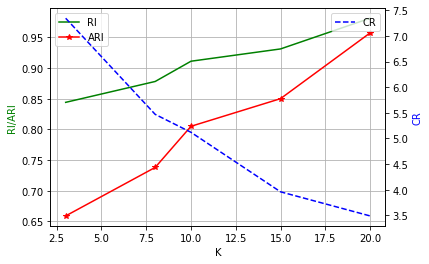

In [86]:
Ks = [3,8,10,15,20]
RI = [0.844,0.878,0.911,0.931,0.981]
ARI = [0.659, 0.738,0.805, 0.850,0.957]
CR = [7.344,5.47,5.12,3.96,3.49]
 
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()           # 做镜像处理
ax1.plot(Ks,RI,'g-',label='RI')
ax1.plot(Ks,ARI,'r*-',label='ARI')
ax2.plot(Ks,CR,'b--',label='CR')
 
ax1.set_xlabel('K')    #设置x轴标题
ax1.set_ylabel('RI/ARI',color = 'g')   #设置Y1轴标题
ax2.set_ylabel('CR',color = 'b') 
ax2.legend(loc=1)
ax1.legend(loc=2)
ax1.grid()

### End